In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

tf.__version__

'1.4.0'

In [5]:
filter_size1 = 5
num_filters1 = 16

filter_size2= 5
num_filters2 = 32

fc_size = 128

In [6]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/mnist/',one_hot=True)

Extracting data/mnist/train-images-idx3-ubyte.gz
Extracting data/mnist/train-labels-idx1-ubyte.gz
Extracting data/mnist/t10k-images-idx3-ubyte.gz
Extracting data/mnist/t10k-labels-idx1-ubyte.gz


In [7]:
data.test.cls = np.argmax(data.test.labels, axis=1)

In [8]:
img_size = 28
img_size_flat = img_size*img_size
img_shape = (img_size, img_size)
num_channels = 1
num_classes = 10

In [9]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

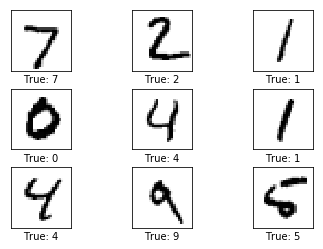

In [10]:
images = data.test.images[0:9]
cls_true = data.test.cls[0:9]
plot_images(images,cls_true)

In [11]:
def new_conv_layer(input,
                  num_input_channels,
                  filter_size,
                  num_filters,
                  use_pooling=True):
    
    # shape of the filter-weights for the convolution.
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    
    # create new weights, biases aka. filters with the given shape.
    weights = tf.Variable(tf.truncated_normal(shape,stddev=0.05))
    biases = tf.Variable(tf.zeros([num_filters]))
    
    layer = tf.nn.conv2d(input=input,
                        filter=weights,
                        strides=[1,1,1,1],
                        padding='SAME')
    
    layer = tf.add(layer,biases)
    
    # Pooling to down-sample the image resolution
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                              ksize=[1,2,2,1],
                              strides=[1,2,2,1],
                              padding='SAME')
        
    layer = tf.nn.relu(layer)
    
    return layer, weights
    
    

In [12]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()
    
    num_features = layer_shape[1:4].num_elements()
    
    layer_flat = tf.reshape(layer, [-1,num_features])
    
    return layer_flat, num_features

In [23]:
def new_fc_layer(input,
                num_inputs,
                num_outputs,
                use_relu=True):
    
    weights = tf.Variable(tf.truncated_normal([num_inputs,num_outputs],stddev=0.05))
    biases = tf.Variable(tf.zeros([num_outputs]))
    
    layer = tf.matmul(input,weights)+biases
    
    if use_relu:
        layer = tf.nn.relu(layer)
        
    return layer

In [14]:
x = tf.placeholder(tf.float32, shape=[None,img_size_flat],name='x')
x_image = tf.reshape(x,[-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)

In [15]:
layer_conv1, weights_conv1 = new_conv_layer(input=x_image,
                                          num_input_channels=num_channels,
                                          filter_size=filter_size1,
                                          num_filters=num_filters1,
                                          use_pooling=True)

In [16]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

In [17]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

In [18]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 32) dtype=float32>

In [19]:
layer_flat, num_features = flatten_layer(layer_conv2)

In [20]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 1568) dtype=float32>

In [21]:
num_features

1568

In [24]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

In [25]:
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

In [26]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)
layer_fc2

<tf.Tensor 'add_1:0' shape=(?, 10) dtype=float32>

In [28]:
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred,axis=1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                       labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)
correct_prediction = tf.equal(y_pred_cls,y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

In [29]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [30]:
train_batch_size = 64

In [42]:
total_iterations=0

In [33]:
def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations
    start_time = time.time()
    
    for i in range(total_iterations,
                   total_iterations + num_iterations):
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)
        feed_dict_train = {x:x_batch,y_true:y_true_batch}
        sess.run(optimizer, feed_dict=feed_dict_train)
    
        if i%100==0:
            acc = sess.run(accuracy,feed_dict=feed_dict_train)
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            print(msg.format(i+1,acc))
        
    total_iterations += num_iterations
    end_time = time.time()
    time_diff = end_time-start_time
    print("Time usage: "+str(timedelta(seconds=int(round(time_diff)))))
    

In [34]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [35]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [39]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = sess.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [40]:
print_test_accuracy()

Accuracy on Test-Set: 5.4% (543 / 10000)


In [43]:
optimize(num_iterations=1)

Optimization Iteration:      1, Training Accuracy:  15.6%
Time usage: 0:00:00


In [44]:
print_test_accuracy()

Accuracy on Test-Set: 7.6% (760 / 10000)


In [45]:
optimize(num_iterations=99) # We already performed 1 iteration above.

Time usage: 0:00:01


Accuracy on Test-Set: 71.5% (7155 / 10000)
Example errors:


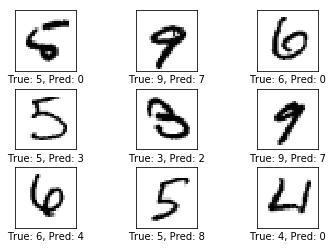

In [46]:
print_test_accuracy(show_example_errors=True)

In [47]:
optimize(num_iterations=900) # We performed 100 iterations above.

Optimization Iteration:    101, Training Accuracy:  67.2%
Optimization Iteration:    201, Training Accuracy:  85.9%
Optimization Iteration:    301, Training Accuracy:  89.1%
Optimization Iteration:    401, Training Accuracy:  89.1%
Optimization Iteration:    501, Training Accuracy:  89.1%
Optimization Iteration:    601, Training Accuracy:  90.6%
Optimization Iteration:    701, Training Accuracy:  93.8%
Optimization Iteration:    801, Training Accuracy:  93.8%
Optimization Iteration:    901, Training Accuracy:  92.2%
Time usage: 0:00:05


Accuracy on Test-Set: 93.0% (9299 / 10000)
Example errors:


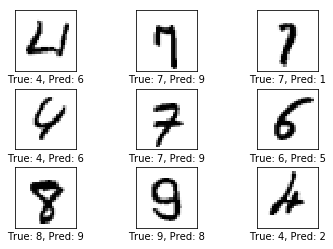

In [48]:
print_test_accuracy(show_example_errors=True)

In [ ]:
optimize(num_iterations=9000) # We performed 1000 iterations above.

Optimization Iteration:   1001, Training Accuracy:  93.8%
Optimization Iteration:   1101, Training Accuracy:  93.8%
Optimization Iteration:   1201, Training Accuracy:  93.8%
Optimization Iteration:   1301, Training Accuracy:  89.1%
Optimization Iteration:   1401, Training Accuracy:  90.6%
Optimization Iteration:   1501, Training Accuracy:  93.8%
Optimization Iteration:   1601, Training Accuracy:  95.3%
Optimization Iteration:   1701, Training Accuracy:  95.3%
Optimization Iteration:   1801, Training Accuracy:  96.9%
Optimization Iteration:   1901, Training Accuracy:  93.8%
Optimization Iteration:   2001, Training Accuracy:  85.9%
Optimization Iteration:   2101, Training Accuracy:  93.8%
Optimization Iteration:   2201, Training Accuracy:  93.8%
Optimization Iteration:   2301, Training Accuracy:  96.9%
Optimization Iteration:   2401, Training Accuracy:  96.9%
Optimization Iteration:   2501, Training Accuracy:  98.4%
Optimization Iteration:   2601, Training Accuracy:  96.9%
Optimization I